In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Time Series Analysis

# Load news data
news_data = pd.read_csv('../data/news_data.csv', parse_dates=['date'])


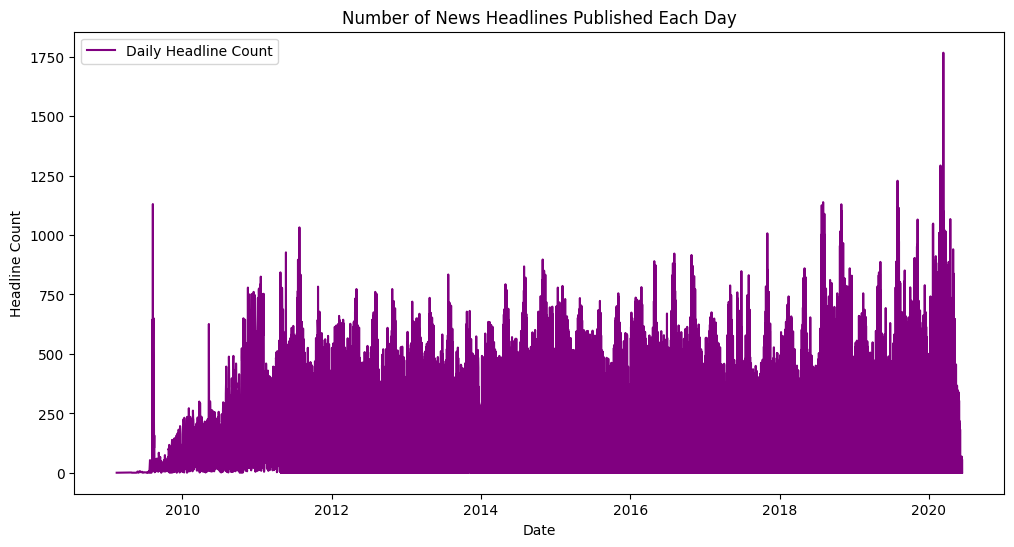

In [4]:
# Group by date to count headlines per day
daily_counts = news_data.groupby('date').size().reset_index(name='headline_count')

# Plot the raw headline counts over time
plt.figure(figsize=(12,6))
plt.plot(daily_counts['date'], daily_counts['headline_count'], color='purple', label='Daily Headline Count')
plt.title('Number of News Headlines Published Each Day')
plt.xlabel('Date')
plt.ylabel('Headline Count')
plt.legend()
plt.show()


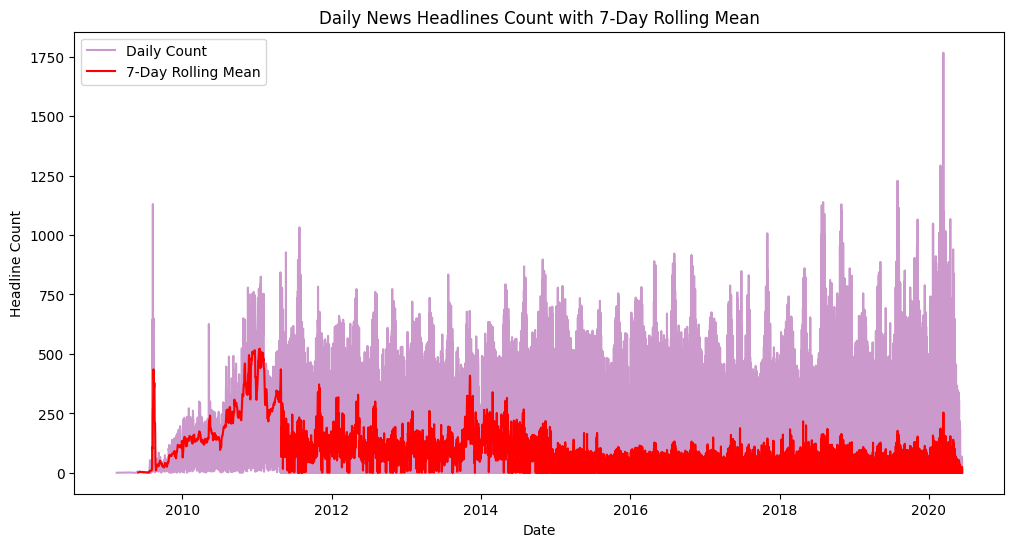

In [5]:
# Smooth the data with a 7-day rolling mean to see clearer trends
daily_counts['rolling_mean'] = daily_counts['headline_count'].rolling(window=7).mean()

plt.figure(figsize=(12,6))
plt.plot(daily_counts['date'], daily_counts['headline_count'], alpha=0.4, label='Daily Count', color='purple')
plt.plot(daily_counts['date'], daily_counts['rolling_mean'], color='red', label='7-Day Rolling Mean')
plt.title('Daily News Headlines Count with 7-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Headline Count')
plt.legend()
plt.show()


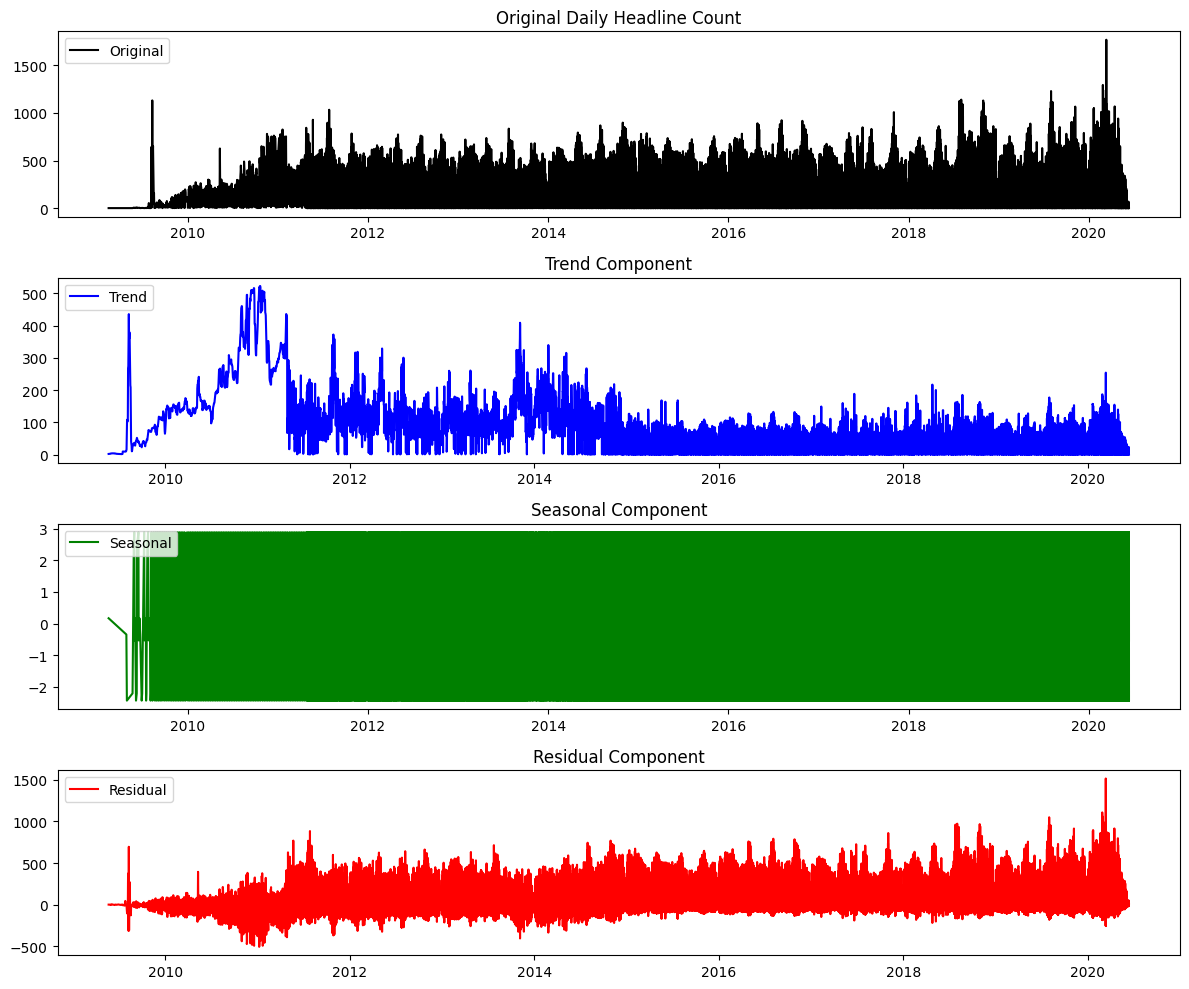

High Activity Days (Headline Count Spikes):
                           headline_count  rolling_mean
date                                                   
2009-08-07 00:00:00+00:00             644    108.142857
2009-08-10 00:00:00+00:00            1130    267.571429
2009-08-12 00:00:00+00:00             532    349.285714
2009-08-13 00:00:00+00:00             651    435.285714
2009-12-09 00:00:00+00:00             167    108.428571
...                                   ...           ...
2020-05-27 00:00:00+00:00             320     46.571429
2020-05-28 00:00:00+00:00             304     44.428571
2020-05-29 00:00:00+00:00             220     33.000000
2020-06-01 00:00:00+00:00             205     31.571429
2020-06-02 00:00:00+00:00             183     27.000000

[2613 rows x 2 columns]


In [6]:
# Decompose the time series to see trend, seasonality, and residuals
# Set 'date' as the index for the decomposition
daily_counts.set_index('date', inplace=True)

# Decompose: using weekly seasonality (period=7)
decomposition = seasonal_decompose(daily_counts['headline_count'].dropna(), model='additive', period=7)

# Plot the decomposition components
plt.figure(figsize=(12,10))

# Original data
plt.subplot(411)
plt.plot(daily_counts.index, daily_counts['headline_count'], label='Original', color='black')
plt.legend(loc='upper left')
plt.title('Original Daily Headline Count')

# Trend component
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.title('Trend Component')

# Seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Residual component
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

# Identifying spikes: days with headline counts significantly above the average
threshold = daily_counts['headline_count'].mean() + daily_counts['headline_count'].std()
spikes = daily_counts[daily_counts['headline_count'] > threshold]

print("High Activity Days (Headline Count Spikes):")
print(spikes)


In [9]:
# Prepare data for correlation analysis

# Filter news data to only include relevant stocks
stocks_of_interest = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
news_data_filtered = news_data[news_data['stock'].isin(stocks_of_interest)].copy()

# Compute average daily sentiment for each stock
avg_sentiment = news_data_filtered.groupby(['date', 'stock'])['Sentiment'].mean().reset_index()


In [10]:
# Load cleaned stock data (daily returns)

apple = pd.read_csv('../data/new_AAPL_data.csv', parse_dates=['date'])
google = pd.read_csv('../data/new_GOOG_data.csv', parse_dates=['date'])
amazon = pd.read_csv('../data/new_AMZN_data.csv', parse_dates=['date'])
meta = pd.read_csv('../data/new_META_data.csv', parse_dates=['date'])
microsoft = pd.read_csv('../data/new_MSFT_data.csv', parse_dates=['date'])
nvidia = pd.read_csv('../data/new_NVDA_data.csv', parse_dates=['date'])
tesla = pd.read_csv('../data/new_TSLA_data.csv', parse_dates=['date'])

# Combine all cleaned stock data into one DataFrame

all_returns = pd.concat([
    apple[['date', 'ticker', 'daily_return']],
    google[['date', 'ticker', 'daily_return']],
    amazon[['date', 'ticker', 'daily_return']],
    meta[['date', 'ticker', 'daily_return']],
    microsoft[['date', 'ticker', 'daily_return']],
    nvidia[['date', 'ticker', 'daily_return']],
    tesla[['date', 'ticker', 'daily_return']]
], ignore_index=True)


In [13]:
# Merge average sentiment data with stock daily returns

all_returns['date'] = all_returns['date'].dt.tz_localize('UTC')

merged_data = pd.merge(
    avg_sentiment,
    all_returns,
    left_on=['date', 'stock'],
    right_on=['date', 'ticker'],
    how='inner'
)

# Drop missing data
merged_data.dropna(subset=['Sentiment', 'daily_return'], inplace=True)


In [15]:
# Compute overall correlation
overall_corr = merged_data['Sentiment'].corr(merged_data['daily_return'])
print(f'Overall correlation between sentiment and daily returns: {overall_corr:.4f}')


Overall correlation between sentiment and daily returns: 0.0913


C:\Users\mike\AppData\Local\Temp\ipykernel_11164\3189088862.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stock_corrs = merged_data.groupby('ticker').apply(


Correlation for each stock:
 ticker
AAPL    0.146716
AMZN   -0.074457
GOOG    0.057545
NVDA    0.103330
TSLA    0.084461
dtype: float64


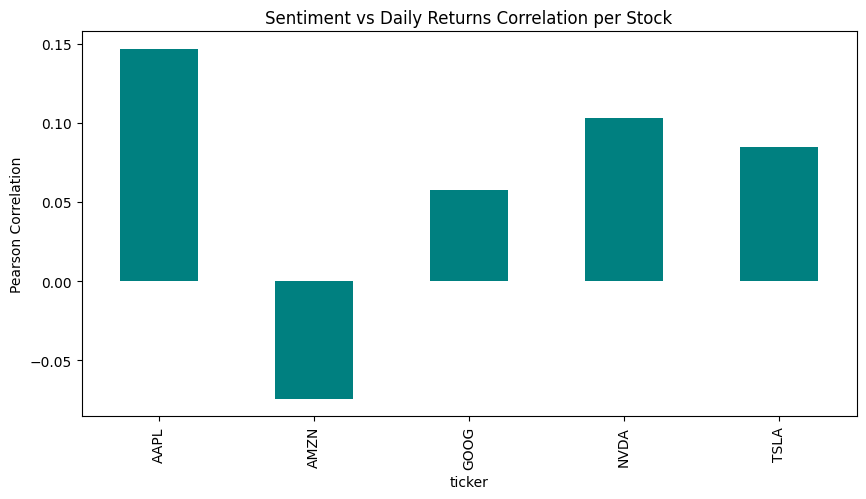

In [16]:
# Compute correlation for each stock
stock_corrs = merged_data.groupby('ticker').apply(
    lambda x: x['Sentiment'].corr(x['daily_return'])
)
print("Correlation for each stock:\n", stock_corrs)

# Plot correlations for each stock
plt.figure(figsize=(10,5))
stock_corrs.plot(kind='bar', color='teal', title='Sentiment vs Daily Returns Correlation per Stock')
plt.ylabel('Pearson Correlation')
plt.show()


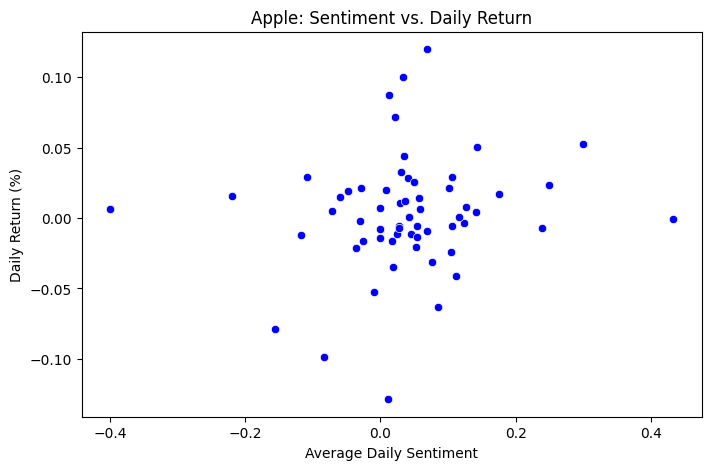

In [17]:
# Visualize relationship for each stock

# ================== Apple (AAPL) =====================
apple_data = merged_data[merged_data['ticker'] == 'AAPL']
plt.figure(figsize=(8,5))
sns.scatterplot(data=apple_data, x='Sentiment', y='daily_return', color='blue')
plt.title('Apple: Sentiment vs. Daily Return')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Return (%)')
plt.show()


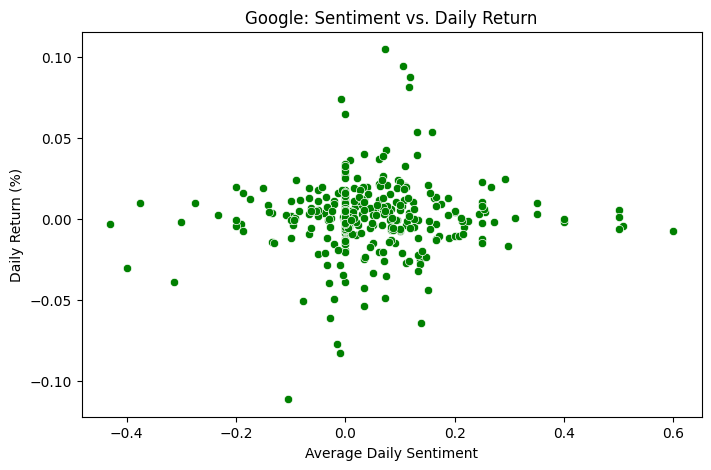

In [18]:

# ================== Google (GOOG) =====================
google_data = merged_data[merged_data['ticker'] == 'GOOG']
plt.figure(figsize=(8,5))
sns.scatterplot(data=google_data, x='Sentiment', y='daily_return', color='green')
plt.title('Google: Sentiment vs. Daily Return')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Return (%)')
plt.show()


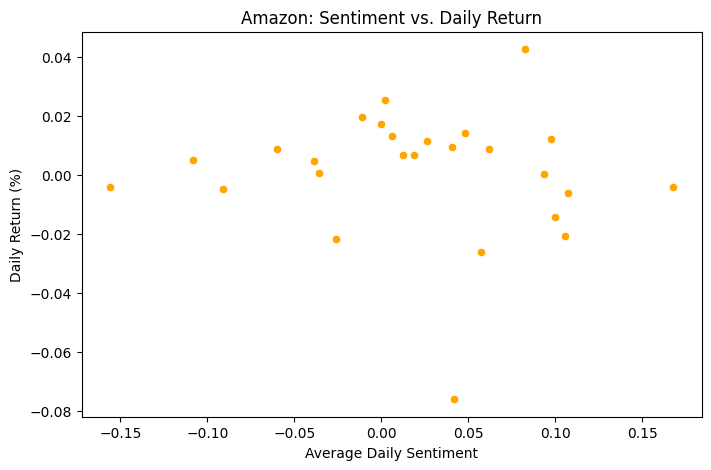

In [19]:
# ================== Amazon (AMZN) =====================
amazon_data = merged_data[merged_data['ticker'] == 'AMZN']
plt.figure(figsize=(8,5))
sns.scatterplot(data=amazon_data, x='Sentiment', y='daily_return', color='orange')
plt.title('Amazon: Sentiment vs. Daily Return')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Return (%)')
plt.show()


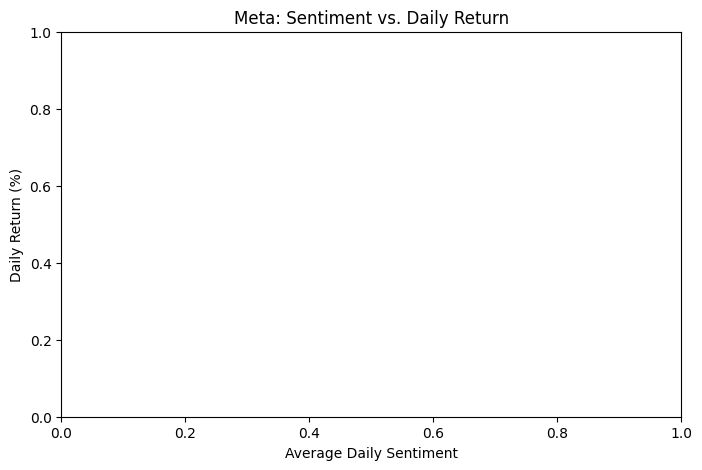

In [20]:
# ================== Meta (META) =====================
meta_data = merged_data[merged_data['ticker'] == 'META']
plt.figure(figsize=(8,5))
sns.scatterplot(data=meta_data, x='Sentiment', y='daily_return', color='purple')
plt.title('Meta: Sentiment vs. Daily Return')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Return (%)')
plt.show()


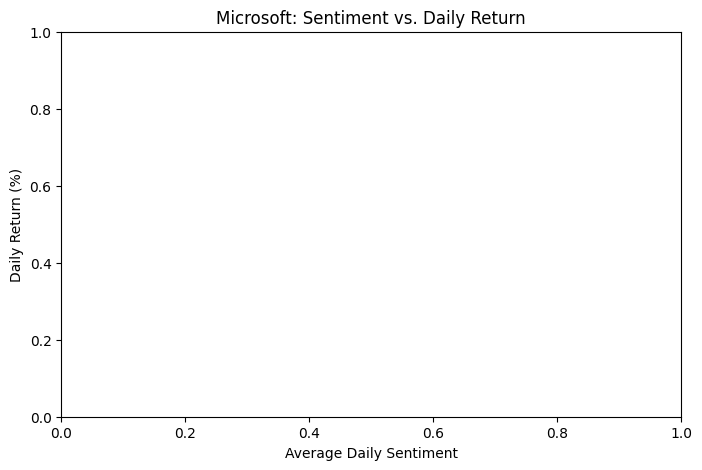

In [22]:
# ================== Microsoft (MSFT) =====================
microsoft_data = merged_data[merged_data['ticker'] == 'MSFT']
plt.figure(figsize=(8,5))
sns.scatterplot(data=microsoft_data, x='Sentiment', y='daily_return', color='red')
plt.title('Microsoft: Sentiment vs. Daily Return')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Return (%)')
plt.show()


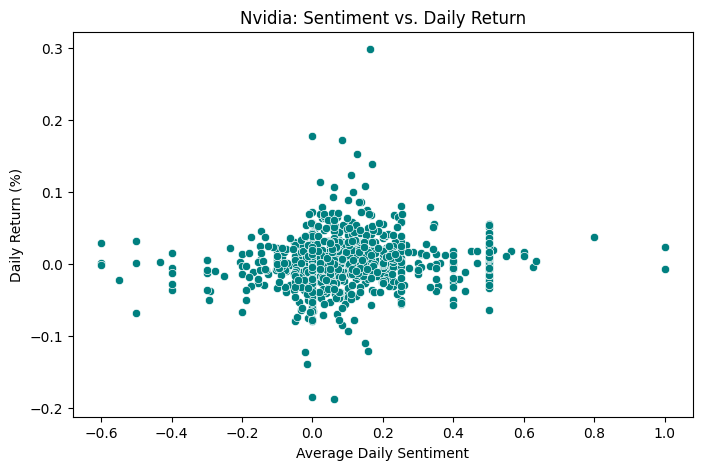

In [23]:
# ================== Nvidia (NVDA) =====================
nvidia_data = merged_data[merged_data['ticker'] == 'NVDA']
plt.figure(figsize=(8,5))
sns.scatterplot(data=nvidia_data, x='Sentiment', y='daily_return', color='teal')
plt.title('Nvidia: Sentiment vs. Daily Return')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Return (%)')
plt.show()


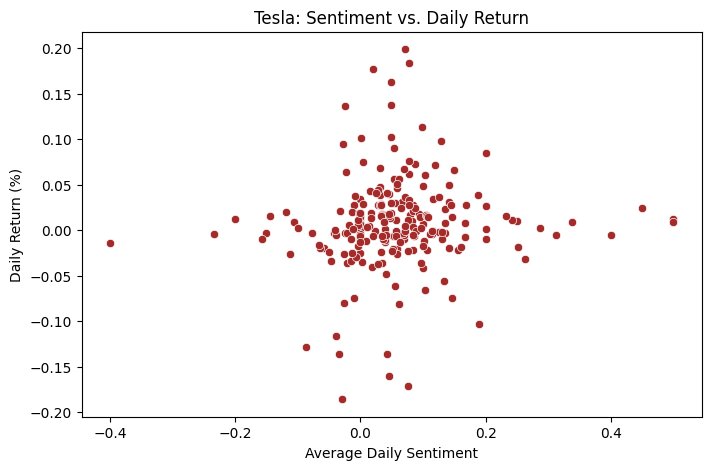

In [24]:
# ================== Tesla (TSLA) =====================
tesla_data = merged_data[merged_data['ticker'] == 'TSLA']
plt.figure(figsize=(8,5))
sns.scatterplot(data=tesla_data, x='Sentiment', y='daily_return', color='brown')
plt.title('Tesla: Sentiment vs. Daily Return')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Return (%)')
plt.show()

